In [1]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from RWM import RWM

In [2]:
# seed = randint(low=1000, high=9999)
# print("Using random seed: ", seed)
seed=1234

In [3]:
m = 50     # number of latent variables
d = m + 4  # dimensionality of x-component

In [4]:
def generate_settings(
    d=10, 
    N=5000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'}):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    #d         = 4 + m                            # Dimensionality of ξ=(θ, z)
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

# Manual Initialization

In [5]:
# # Generate Manifold
# θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
# ystar     = data_generator(θ0, m, seed=1234)  # Observed data
# resetwarnings()
# manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False)

# # Generate target distribution
# ξ0 = manifold.sample()               # Initial point on manifold  
# ε0 = 10.0                            # Starting epsilon
# logηε0 = manifold.generate_logηε(ε0)  # Target filamentary distribution

# # Sample from it using RWM
# s_rwm, a_rwm = RWM(x0=ξ0, s=0.001, N=5000, logpi=logηε0)

# # Add velocities to particles
# v0_manual = randn(*s_rwm.shape)
# z0_manual = np.hstack((s_rwm, v0_manual))

In [6]:
def generate_initial_particles(ϵ0, N=5000):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)

    # Generate target distribution
    ξ0 = manifold.sample()               # Initial point on manifold                            # Starting epsilon
    logηε0 = manifold.generate_logηε(ε0)  # Target filamentary distribution

    # Sample from it using RWM
    s_rwm, a_rwm = RWM(x0=ξ0, s=0.001, N=N, logpi=logηε0)

    # Add velocities to particles
    v0_manual = randn(*s_rwm.shape)
    z0_manual = np.hstack((s_rwm, v0_manual))
    return z0_manual

def generate_initial_particles_on_manifold(N=5000, θtrue=False):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample N times
    x0_manual = np.vstack([manifold.sample(fromtheta=θtrue) for _ in range(N)])
    v0_manual = randn(*x0_manual.shape)
    return np.hstack((x0_manual, v0_manual))

def generate_particles_on_manifold_then_rwm(ϵ0, N=5000, θtrue=False, δrwm=0.001):
    """First, generate particles on the manifold. Then use RWM to actually sample from a filamentary
    distribution of sorts."""
    # Generate manifold (used only to generate filamentary distribution)
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample on manifold
    on_manifold = generate_initial_particles_on_manifold(N=N, θtrue=θtrue)
    x0_on_manifold = on_manifold[:, :on_manifold.shape[1]//2]
    # Store filamentary samples
    filamentary_samples = []
    for x0 in x0_on_manifold:
        filamentary_samples.append(RWM(x0, s=δrwm, N=1, logpi=manifold.generate_logηε(ϵ0))[0].flatten())
    # Create array
    v0_manual = randn(*x0_on_manifold.shape)
    x0_manual = np.vstack(filamentary_samples)
    return np.hstack((x0_manual, v0_manual))

In [7]:
samples_around_manifold = generate_particles_on_manifold_then_rwm(ϵ0=10, N=1000, θtrue=True)

In [8]:
# samples_on_manifold = generate_initial_particles_on_manifold(1000, θtrue=True)

# Settings

In [6]:
SETTINGS_MANUAL_RWM_0001 = generate_settings(
    δ=0.001,
    d=d, 
    integrator='rwm', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    min_pm=0.0
)

SETTINGS_MANUAL_RWM_001 = generate_settings(
    δ=0.01,
    d=d, 
    integrator='rwm', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    min_pm=0.0
)

SETTINGS_MANUAL_RWM_01 = generate_settings(
    δ=0.1,
    d=d, 
    integrator='rwm', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    min_pm=0.0
)

SETTINGS_MANUAL_RWM_ADAPTIVE = generate_settings(
    δ=0.01,
    d=d, 
    integrator='rwm', 
    initialization='manual', 
    adaptiveδ=True,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    min_pm=0.0
)

SETTINGS_MANUAL_RT_0001 = generate_settings(
    δ=0.001,
    d=d, 
    integrator='rwm_then_thug', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    pm_switch=0.1,
    min_pm=0.0
)

SETTINGS_MANUAL_RT_001 = generate_settings(
    δ=0.01,
    d=d, 
    integrator='rwm_then_thug', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    pm_switch=0.1,
    min_pm=0.0
)

SETTINGS_MANUAL_RT_01 = generate_settings(
    δ=0.1,
    d=d, 
    integrator='rwm_then_thug', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    pm_switch=0.1,
    min_pm=0.0
)

SETTINGS_MANUAL_THUG_01 = generate_settings(
    δ=0.1,
    d=d, 
    integrator='thug', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    pm_switch=0.1,
    min_pm=0.0,
    verbose=True
)


SETTINGS_MANUAL_RT_ADAPTIVE = generate_settings(
    δ=0.01,
    d=d, 
    integrator='rwm_then_thug', 
    initialization='manual', 
    adaptiveδ=True,
    adaptiveε=True,
    z0_manual=z0_manual, 
    ε0_manual=ε0,
    min_pm=0.0
)

# MS-RWM

In [7]:
MS_RWM_MAN_0001 = MSAdaptive(SETTINGS_MANUAL_RWM_0001)
_ = MS_RWM_MAN_0001.sample()

/Users/maurocamara/Documents/University/ManifoldSampling/markov_snippets.py:224: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


ValueError was raised:  probabilities contain NaN


In [14]:
MS_RWM_MAN_001 = MSAdaptive(SETTINGS_MANUAL_RWM_001)
_ = MS_RWM_MAN_001.sample()

/Users/maurocamara/Documents/University/ManifoldSampling/markov_snippets.py:224: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


ValueError was raised:  probabilities contain NaN


In [25]:
MS_RWM_MAN_01 = MSAdaptive(SETTINGS_MANUAL_RWM_01)
_ = MS_RWM_MAN_01.sample()

ValueError was raised:  probabilities contain NaN


/Users/maurocamara/Documents/University/ManifoldSampling/markov_snippets.py:224: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


# SMC-RWM

In [36]:
SMC_RWM_MAN_0001 = SMCAdaptive(SETTINGS_MANUAL_RWM_0001)
_ = SMC_RWM_MAN_0001.sample()

Error was raised:  probabilities contain NaN


/Users/maurocamara/Documents/University/ManifoldSampling/markov_snippets.py:551: RuntimeWarning: invalid value encountered in subtract
  W = exp(logw - logsumexp(logw))


In [38]:
SMC_RWM_MAN_001 = SMCAdaptive(SETTINGS_MANUAL_RWM_001)
_ = SMC_RWM_MAN_001.sample()

Error was raised:  probabilities contain NaN


/Users/maurocamara/Documents/University/ManifoldSampling/markov_snippets.py:551: RuntimeWarning: invalid value encountered in subtract
  W = exp(logw - logsumexp(logw))


In [40]:
SMC_RWM_MAN_01 = SMCAdaptive(SETTINGS_MANUAL_RWM_01)
_ = SMC_RWM_MAN_01.sample()

Error was raised:  


# MS-RT

In [51]:
MS_RT_MAN_01 = MSAdaptive(SETTINGS_MANUAL_RT_01)
_ = MS_RT_MAN_01.sample()

ValueError was raised:  


# MS-THUG

In [72]:
z0_manual_1 = generate_initial_particles(ϵ0=10, N=1000)

In [74]:
MS_RT_MAN_01_1000P = MSAdaptive(generate_settings(
    δ=0.01,
    d=d, 
    N=1000,
    integrator='rwm_then_thug', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=z0_manual_1, 
    ε0_manual=ε0,
    pm_switch=0.1,
    min_pm=0.0,
    verbose=True,
    quantile_value=0.3,
    use_autograd=False
))
_ = MS_RT_MAN_01_1000P.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 9.4619590818408650
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8830000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Trajectories constructed.
	Epsilon: 8.9280927741839022
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8820000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Trajectories constructed.
	Epsilon: 7.9171047165600443
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8860000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Trajectories constructed.
	Epsilon: 6.5435495160513781
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8490000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  5
	Trajectories constructed.
	Epsilo

	Trajectories constructed.
	Epsilon: 0.8961290106955210
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9530000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  38
	Trajectories constructed.
	Epsilon: 0.8959427180743571
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  39
	Trajectories constructed.
	Epsilon: 0.8957065963649237
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9530000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  40
	Trajectories constructed.
	Epsilon: 0.8954782288323234
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9570000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  41
	Trajectories constructed.
	Epsilon: 0.8952037760177901
	Weights computed and normalized.
	P

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9620000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  74
	Trajectories constructed.
	Epsilon: 0.8869478800206537
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9670000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  75
	Trajectories constructed.
	Epsilon: 0.8867153778897628
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9570000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 0.8864806699087658
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9630000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 0.8862721854604492
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 

In [ ]:
# TEST = MSAdaptive(generate_settings(
#     δ=0.01,
#     d=d, 
#     N=1000,
#     integrator='rwm_then_thug', 
#     initialization='manual', 
#     adaptiveδ=True,
#     adaptiveε=True,
#     z0_manual=samples_around_manifold, 
#     ε0_manual=10.0,
#     pm_switch=0.1,
#     min_pm=0.0,
#     verbose=True,
#     quantile_value=0.3,
#     use_autograd=False
# ))
# _ = TEST.sample()

In [8]:
samples_around_manifold = generate_particles_on_manifold_then_rwm(ϵ0=10, N=2000, θtrue=True, δrwm=0.001)

In [9]:
# εs = np.geomspace(start=10.0, stop=1e-5, num=20, endpoint=True)

In [10]:
TEST = MSAdaptive(generate_settings(
    δ=0.01,
    d=d, 
    N=2000,
    integrator='rwm_then_thug', 
    initialization='manual', 
    adaptiveδ=True,
    adaptiveε=True,
    z0_manual=samples_around_manifold, 
    ε0_manual=10.0,
    pm_switch=0.1,
    min_pm=0.0,
    verbose=True,
    quantile_value=0.1,
    use_autograd=False
))
_ = TEST.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 0.8176877373666241
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5820000000000000
	Step-size adapted to: 0.0119243805865067
Iteration:  2
	Trajectories constructed.
	Epsilon: 0.5615815299954544
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Step-size adapted to: 0.0120804095248290
Iteration:  3
	Trajectories constructed.
	Epsilon: 0.4569965764576469
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1010000000000000
	Step-size adapted to: 0.0113258202046025
Iteration:  4
	Trajectories constructed.
	Epsilon: 0.3873680954063192
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0385000000000000
	Step-size adapted to: 0.0102916727049335


####################################
### SWITCHING TO THUG

	Trajectories constructed.
	Epsilon: 0.2325667373759965
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3365000000000000
	Step-size adapted to: 0.0851006856887549
Iteration:  38
	Trajectories constructed.
	Epsilon: 0.2320404618493709
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1760000000000000
	Step-size adapted to: 0.0828337090765788
Iteration:  39
	Trajectories constructed.
	Epsilon: 0.2306806746559387
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0395000000000000
	Step-size adapted to: 0.0753079037663465
Iteration:  40
	Trajectories constructed.
	Epsilon: 0.2304817335747608
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0275000000000000
	Step-size adapted to: 0.0680562856534409
Iteration:  41
	Trajectories constructed.
	Epsilon: 0.2298648664348695
	Weights computed and normalized.
	Particles Res

	Trajectories constructed.
	Epsilon: 0.1898625440668829
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2195000000000000
	Step-size adapted to: 0.0725361525180019
Iteration:  75
	Trajectories constructed.
	Epsilon: 0.1894043505592929
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2125000000000000
	Step-size adapted to: 0.0719042298768175
Iteration:  76
	Trajectories constructed.
	Epsilon: 0.1886567994780937
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1185000000000000
	Step-size adapted to: 0.0680052625752468
Iteration:  77
	Trajectories constructed.
	Epsilon: 0.1874736612796300
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2150000000000000
	Step-size adapted to: 0.0674971309812745
Iteration:  78
	Trajectories constructed.
	Epsilon: 0.1868218581275429
	Weights computed and normalized.
	Particles Res

	Trajectories constructed.
	Epsilon: 0.1728420054546824
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0760000000000000
	Step-size adapted to: 0.0358407349026959
Iteration:  112
	Trajectories constructed.
	Epsilon: 0.1725935828769928
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5935000000000000
	Step-size adapted to: 0.0429843068882661
Iteration:  113
	Trajectories constructed.
	Epsilon: 0.1722280154766962
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0190000000000000
	Step-size adapted to: 0.0386804805017628
Iteration:  114
	Trajectories constructed.
	Epsilon: 0.1720875705409364
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0230000000000000
	Step-size adapted to: 0.0348772618165733
Iteration:  115
	Trajectories constructed.
	Epsilon: 0.1718801543960487
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1660339882996208
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1420000000000000
	Step-size adapted to: 0.0232158467018271
Iteration:  149
	Trajectories constructed.
	Epsilon: 0.1659392073824225
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1895000000000000
	Step-size adapted to: 0.0227504538123599
Iteration:  150
	Trajectories constructed.
	Epsilon: 0.1658901271468384
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5450000000000000
	Step-size adapted to: 0.0266312434680998
Iteration:  151
	Trajectories constructed.
	Epsilon: 0.1657479762919785
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0780000000000000
	Step-size adapted to: 0.0246822680470636
Iteration:  152
	Trajectories constructed.
	Epsilon: 0.1656178289752724
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1638968686511373
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0445000000000000
	Step-size adapted to: 0.0157499169618467
Iteration:  186
	Trajectories constructed.
	Epsilon: 0.1638600437947255
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0760000000000000
	Step-size adapted to: 0.0145826883101187
Iteration:  187
	Trajectories constructed.
	Epsilon: 0.1638175626005601
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6075000000000000
	Step-size adapted to: 0.0176120811052174
Iteration:  188
	Trajectories constructed.
	Epsilon: 0.1637462786510191
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1300000000000000
	Step-size adapted to: 0.0167531297739759
Iteration:  189
	Trajectories constructed.
	Epsilon: 0.1636479563369167
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1622223816692774
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0870000000000000
	Step-size adapted to: 0.0150117780000012
Iteration:  223
	Trajectories constructed.
	Epsilon: 0.1621274136784648
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5560000000000000
	Step-size adapted to: 0.0176694134834596
Iteration:  224
	Trajectories constructed.
	Epsilon: 0.1620546928076217
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1185000000000000
	Step-size adapted to: 0.0167112992594707
Iteration:  225
	Trajectories constructed.
	Epsilon: 0.1619948424973130
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0130000000000000
	Step-size adapted to: 0.0149930250005676
Iteration:  226
	Trajectories constructed.
	Epsilon: 0.1619065341902494
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1613056345108163
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2820000000000000
	Step-size adapted to: 0.0067536634635258
Iteration:  260
	Trajectories constructed.
	Epsilon: 0.1612914133473813
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3130000000000000
	Step-size adapted to: 0.0070398375385562
Iteration:  261
	Trajectories constructed.
	Epsilon: 0.1612813707740287
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0890000000000000
	Step-size adapted to: 0.0065606198839355
Iteration:  262
	Trajectories constructed.
	Epsilon: 0.1612766130797878
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0155000000000000
	Step-size adapted to: 0.0058934118592975
Iteration:  263
	Trajectories constructed.
	Epsilon: 0.1612714147898661
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1609990898572335
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1670000000000000
	Step-size adapted to: 0.0058801665891308
Iteration:  297
	Trajectories constructed.
	Epsilon: 0.1609922111208816
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1970000000000000
	Step-size adapted to: 0.0057839398937801
Iteration:  298
	Trajectories constructed.
	Epsilon: 0.1609783610843579
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5850000000000000
	Step-size adapted to: 0.0069073433063735
Iteration:  299
	Trajectories constructed.
	Epsilon: 0.1609697636075363
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1815000000000000
	Step-size adapted to: 0.0067418548879819
Iteration:  300
	Trajectories constructed.
	Epsilon: 0.1609640667318192
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1607381306158975
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4965000000000000
	Step-size adapted to: 0.0073473161214375
Iteration:  334
	Trajectories constructed.
	Epsilon: 0.1607260634045672
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1435000000000000
	Step-size adapted to: 0.0070363184996199
Iteration:  335
	Trajectories constructed.
	Epsilon: 0.1607149966731922
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5310000000000000
	Step-size adapted to: 0.0081791243155385
Iteration:  336
	Trajectories constructed.
	Epsilon: 0.1607054181718614
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1120000000000000
	Step-size adapted to: 0.0077105158580356
Iteration:  337
	Trajectories constructed.
	Epsilon: 0.1606934702831336
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1605745066835031
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0545000000000000
	Step-size adapted to: 0.0026460953299564
Iteration:  371
	Trajectories constructed.
	Epsilon: 0.1605736013632756
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2515000000000000
	Step-size adapted to: 0.0026746942987975
Iteration:  372
	Trajectories constructed.
	Epsilon: 0.1605727070851567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1775000000000000
	Step-size adapted to: 0.0026053970785997
Iteration:  373
	Trajectories constructed.
	Epsilon: 0.1605718393225694
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0390000000000000
	Step-size adapted to: 0.0023680932441381
Iteration:  374
	Trajectories constructed.
	Epsilon: 0.1605703451879552
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1605391351996004
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0410000000000000
	Step-size adapted to: 0.0018059469730051
Iteration:  408
	Trajectories constructed.
	Epsilon: 0.1605386586591965
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5585000000000000
	Step-size adapted to: 0.0021283245905360
Iteration:  409
	Trajectories constructed.
	Epsilon: 0.1605381628604466
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0435000000000000
	Step-size adapted to: 0.0019388307651321
Iteration:  410
	Trajectories constructed.
	Epsilon: 0.1605376457372932
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3380000000000000
	Step-size adapted to: 0.0020464060187815
Iteration:  411
	Trajectories constructed.
	Epsilon: 0.1605370713894436
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1605261575527010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  445
	Trajectories constructed.
	Epsilon: 0.1605260877205373
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0280000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  446
	Trajectories constructed.
	Epsilon: 0.1605259062838158
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3885000000000000
	Step-size adapted to: 0.0010824749069725
Iteration:  447
	Trajectories constructed.
	Epsilon: 0.1605258001421667
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1155000000000000
	Step-size adapted to: 0.0010222437844704
Iteration:  448
	Trajectories constructed.
	Epsilon: 0.1605255594103560
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1605165122322440
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0635000000000000
	Step-size adapted to: 0.0014084643536622
Iteration:  482
	Trajectories constructed.
	Epsilon: 0.1605162516732990
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0765000000000000
	Step-size adapted to: 0.0013044089156918
Iteration:  483
	Trajectories constructed.
	Epsilon: 0.1605160986089569
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5875000000000000
	Step-size adapted to: 0.0015597101457635
Iteration:  484
	Trajectories constructed.
	Epsilon: 0.1605158602169421
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0170000000000000
	Step-size adapted to: 0.0014021405034053
Iteration:  485
	Trajectories constructed.
	Epsilon: 0.1605157908860634
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1605099312517441
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1035000000000000
	Step-size adapted to: 0.0011179537440055
Iteration:  519
	Trajectories constructed.
	Epsilon: 0.1605097482498023
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3250000000000000
	Step-size adapted to: 0.0011723379466807
Iteration:  520
	Trajectories constructed.
	Epsilon: 0.1605096293155879
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1095000000000000
	Step-size adapted to: 0.0011037903174832
Iteration:  521
	Trajectories constructed.
	Epsilon: 0.1605093979819195
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1985000000000000
	Step-size adapted to: 0.0010865418085482
Iteration:  522
	Trajectories constructed.
	Epsilon: 0.1605086360088749
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1605030474459082
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0775000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  556
	Trajectories constructed.
	Epsilon: 0.1605029788614582
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1200000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  557
	Trajectories constructed.
	Epsilon: 0.1605029337421522
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3950000000000000
	Step-size adapted to: 0.0010859986734391
Iteration:  558
	Trajectories constructed.
	Epsilon: 0.1605028141603497
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1395000000000000
	Step-size adapted to: 0.0010379524765240
Iteration:  559
	Trajectories constructed.
	Epsilon: 0.1605024281099174
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604956104711306
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2305000000000000
	Step-size adapted to: 0.0010123253385682
Iteration:  593
	Trajectories constructed.
	Epsilon: 0.1604952933759137
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4975000000000000
	Step-size adapted to: 0.0011571961880508
Iteration:  594
	Trajectories constructed.
	Epsilon: 0.1604950376698305
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0225000000000000
	Step-size adapted to: 0.0010431552349636
Iteration:  595
	Trajectories constructed.
	Epsilon: 0.1604949271677078
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0540000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  596
	Trajectories constructed.
	Epsilon: 0.1604947267793091
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604866050292895
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4720000000000000
	Step-size adapted to: 0.0013671796933763
Iteration:  630
	Trajectories constructed.
	Epsilon: 0.1604863833853446
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1405000000000000
	Step-size adapted to: 0.0013073471400149
Iteration:  631
	Trajectories constructed.
	Epsilon: 0.1604862308844051
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4690000000000000
	Step-size adapted to: 0.0014732929536190
Iteration:  632
	Trajectories constructed.
	Epsilon: 0.1604858637970938
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0410000000000000
	Step-size adapted to: 0.0013404427904317
Iteration:  633
	Trajectories constructed.
	Epsilon: 0.1604856327084982
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604738167297672
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6770000000000000
	Step-size adapted to: 0.0017172943500791
Iteration:  667
	Trajectories constructed.
	Epsilon: 0.1604735733105660
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0485000000000000
	Step-size adapted to: 0.0015683121854902
Iteration:  668
	Trajectories constructed.
	Epsilon: 0.1604732642713073
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1710000000000000
	Step-size adapted to: 0.0015227227266733
Iteration:  669
	Trajectories constructed.
	Epsilon: 0.1604730330398569
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2455000000000000
	Step-size adapted to: 0.0015345696754351
Iteration:  670
	Trajectories constructed.
	Epsilon: 0.1604727160309229
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604630813575987
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0555000000000000
	Step-size adapted to: 0.0012284460540897
Iteration:  704
	Trajectories constructed.
	Epsilon: 0.1604627012056595
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5440000000000000
	Step-size adapted to: 0.0014372764951988
Iteration:  705
	Trajectories constructed.
	Epsilon: 0.1604623967028036
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1220000000000000
	Step-size adapted to: 0.0013617218974717
Iteration:  706
	Trajectories constructed.
	Epsilon: 0.1604621502301767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0165000000000000
	Step-size adapted to: 0.0012238480081114
Iteration:  707
	Trajectories constructed.
	Epsilon: 0.1604617517679238
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604558225662323
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4290000000000000
	Step-size adapted to: 0.0011046184707400
Iteration:  741
	Trajectories constructed.
	Epsilon: 0.1604557210664903
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0050000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  742
	Trajectories constructed.
	Epsilon: 0.1604557136710212
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0210000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  743
	Trajectories constructed.
	Epsilon: 0.1604556683841657
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5065000000000000
	Step-size adapted to: 0.0011482625800390
Iteration:  744
	Trajectories constructed.
	Epsilon: 0.1604556328495853
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604479576003575
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1285000000000000
	Step-size adapted to: 0.0013549302811743
Iteration:  778
	Trajectories constructed.
	Epsilon: 0.1604477994292174
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3310000000000000
	Step-size adapted to: 0.0014251114198038
Iteration:  779
	Trajectories constructed.
	Epsilon: 0.1604475592385435
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0525000000000000
	Step-size adapted to: 0.0013040828542223
Iteration:  780
	Trajectories constructed.
	Epsilon: 0.1604474953473974
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1825000000000000
	Step-size adapted to: 0.0012734757840707
Iteration:  781
	Trajectories constructed.
	Epsilon: 0.1604473120028961
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604421860400815
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1010000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  815
	Trajectories constructed.
	Epsilon: 0.1604420625803191
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3560000000000000
	Step-size adapted to: 0.0010650268392313
Iteration:  816
	Trajectories constructed.
	Epsilon: 0.1604419493194104
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0065000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  817
	Trajectories constructed.
	Epsilon: 0.1604418577206767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1335000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  818
	Trajectories constructed.
	Epsilon: 0.1604418386075812
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604364570499627
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1045000000000000
	Step-size adapted to: 0.0010621020388672
Iteration:  852
	Trajectories constructed.
	Epsilon: 0.1604362533593977
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2010000000000000
	Step-size adapted to: 0.0010468126750725
Iteration:  853
	Trajectories constructed.
	Epsilon: 0.1604360799569678
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0785000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  854
	Trajectories constructed.
	Epsilon: 0.1604360193710888
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0235000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  855
	Trajectories constructed.
	Epsilon: 0.1604358646591903
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604306182711938
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5065000000000000
	Step-size adapted to: 0.0011482625800390
Iteration:  889
	Trajectories constructed.
	Epsilon: 0.1604304996689020
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0650000000000000
	Step-size adapted to: 0.0010573333173629
Iteration:  890
	Trajectories constructed.
	Epsilon: 0.1604300731952657
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6290000000000000
	Step-size adapted to: 0.0012907842766084
Iteration:  891
	Trajectories constructed.
	Epsilon: 0.1604299381111193
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0920000000000000
	Step-size adapted to: 0.0012047234035841
Iteration:  892
	Trajectories constructed.
	Epsilon: 0.1604296251784013
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604223664278374
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2205000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  926
	Trajectories constructed.
	Epsilon: 0.1604222091712136
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1665000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  927
	Trajectories constructed.
	Epsilon: 0.1604220035079758
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4200000000000000
	Step-size adapted to: 0.0010996588551261
Iteration:  928
	Trajectories constructed.
	Epsilon: 0.1604218116933304
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1085000000000000
	Step-size adapted to: 0.0010348432852133
Iteration:  929
	Trajectories constructed.
	Epsilon: 0.1604215544398580
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604168204290993
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1175000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  963
	Trajectories constructed.
	Epsilon: 0.1604167559691375
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0570000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  964
	Trajectories constructed.
	Epsilon: 0.1604166919719547
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3085000000000000
	Step-size adapted to: 0.0010400304587666
Iteration:  965
	Trajectories constructed.
	Epsilon: 0.1604165985894055
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4780000000000000
	Step-size adapted to: 0.0011773309856464
Iteration:  966
	Trajectories constructed.
	Epsilon: 0.1604163733037244
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1604110715185450
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3150000000000000
	Step-size adapted to: 0.0010434160563737
Iteration:  1000
	Trajectories constructed.
	Epsilon: 0.1604109441884922
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1465000000000000
	Step-size adapted to: 0.0010007502813203
Iteration:  1001
	Trajectories constructed.
	Epsilon: 0.1604108414777131
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1260000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1002
	Trajectories constructed.
	Epsilon: 0.1604107350623126
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4405000000000000
	Step-size adapted to: 0.0011109883227209
Iteration:  1003
	Trajectories constructed.
	Epsilon: 0.1604105816263497
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.1604045904013346
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1005000000000000
	Step-size adapted to: 0.0012330613751108
Iteration:  1037
	Trajectories constructed.
	Epsilon: 0.1604036470551090
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2525000000000000
	Step-size adapted to: 0.0012470116386820
Iteration:  1038
	Trajectories constructed.
	Epsilon: 0.1604032833691327
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4285000000000000
	Step-size adapted to: 0.0013771277643360
Iteration:  1039
	Trajectories constructed.
	Epsilon: 0.1604029139219678
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1375000000000000
	Step-size adapted to: 0.0013148860396352
Iteration:  1040
	Trajectories constructed.
	Epsilon: 0.1604026234694404
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.1603952105573849
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1355000000000000
	Step-size adapted to: 0.0011476885922579
Iteration:  1074
	Trajectories constructed.
	Epsilon: 0.1603948246947984
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2990000000000000
	Step-size adapted to: 0.0011879747897902
Iteration:  1075
	Trajectories constructed.
	Epsilon: 0.1603946006716656
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2520000000000000
	Step-size adapted to: 0.0012011146492114
Iteration:  1076
	Trajectories constructed.
	Epsilon: 0.1603944060664365
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0235000000000000
	Step-size adapted to: 0.0010832870676750
Iteration:  1077
	Trajectories constructed.
	Epsilon: 0.1603941403465266
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.1603849938653723
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4420000000000000
	Step-size adapted to: 0.0011118218765065
Iteration:  1111
	Trajectories constructed.
	Epsilon: 0.1603848631204952
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0765000000000000
	Step-size adapted to: 0.0010296819827959
Iteration:  1112
	Trajectories constructed.
	Epsilon: 0.1603845828256262
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5655000000000000
	Step-size adapted to: 0.0012177440407059
Iteration:  1113
	Trajectories constructed.
	Epsilon: 0.1603844262421595
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0675000000000000
	Step-size adapted to: 0.0011227151582559
Iteration:  1114
	Trajectories constructed.
	Epsilon: 0.1603842262296279
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.1603785308328629
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2410000000000000
	Step-size adapted to: 0.0011864907490217
Iteration:  1148
	Trajectories constructed.
	Epsilon: 0.1603782068064029
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2880000000000000
	Step-size adapted to: 0.0012214027581602
Iteration:  1149
	Trajectories constructed.
	Epsilon: 0.1603779008618381
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2710000000000000
	Step-size adapted to: 0.0012466999247382
Iteration:  1150
	Trajectories constructed.
	Epsilon: 0.1603775881420069
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0710000000000000
	Step-size adapted to: 0.0011514246479847
Iteration:  1151
	Trajectories constructed.
	Epsilon: 0.1603772590693792
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.1603696454504832
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1185
	Trajectories constructed.
	Epsilon: 0.1603696026510968
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0355000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1186
	Trajectories constructed.
	Epsilon: 0.1603694523034648
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1187
	Trajectories constructed.
	Epsilon: 0.1603694222443759
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0050000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1188
	Trajectories constructed.
	Epsilon: 0.1603693005072511
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.1603611767382477
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5890000000000000
	Step-size adapted to: 0.0014795677732186
Iteration:  1222
	Trajectories constructed.
	Epsilon: 0.1603610127760540
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1460000000000000
	Step-size adapted to: 0.0014187128260483
Iteration:  1223
	Trajectories constructed.
	Epsilon: 0.1603607470935894
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3840000000000000
	Step-size adapted to: 0.0015322695464500
Iteration:  1224
	Trajectories constructed.
	Epsilon: 0.1603603998581725
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0705000000000000
	Step-size adapted to: 0.0014148167253704
Iteration:  1225
	Trajectories constructed.
	Epsilon: 0.1603601400790834
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.1603473348477713
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1275000000000000
	Step-size adapted to: 0.0012089473230437
Iteration:  1259
	Trajectories constructed.
	Epsilon: 0.1603469216319040
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4975000000000000
	Step-size adapted to: 0.0013819561562680
Iteration:  1260
	Trajectories constructed.
	Epsilon: 0.1603465781920100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1825000000000000
	Step-size adapted to: 0.0013495213850537
Iteration:  1261
	Trajectories constructed.
	Epsilon: 0.1603462599141871
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0540000000000000
	Step-size adapted to: 0.0012358388867336
Iteration:  1262
	Trajectories constructed.
	Epsilon: 0.1603458843422601
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.1603380430933278
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0760000000000000
	Step-size adapted to: 0.0010376930208382
Iteration:  1296
	Trajectories constructed.
	Epsilon: 0.1603377432279662
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5595000000000000
	Step-size adapted to: 0.0012235420843514
Iteration:  1297
	Trajectories constructed.
	Epsilon: 0.1603375674572530
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0330000000000000
	Step-size adapted to: 0.0011087685665715
Iteration:  1298
	Trajectories constructed.
	Epsilon: 0.1603373194184695
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1299
	Trajectories constructed.
	Epsilon: 0.1603372975550099
	Weights computed and normalized.
	Parti

In [17]:
# Maybe the problem is indeed adapting the stepsize
TEST2 = MSAdaptive(generate_settings(
    δ=0.01,
    d=d, 
    N=2000,
    integrator='rwm_then_thug', 
    initialization='manual', 
    adaptiveδ=False,
    adaptiveε=True,
    z0_manual=samples_around_manifold, 
    ε0_manual=10.0,
    pm_switch=0.1,
    min_pm=0.0,
    verbose=True,
    quantile_value=0.1,
    use_autograd=False
))
_ = TEST2.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 0.8176877373666241
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5920000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Trajectories constructed.
	Epsilon: 0.5608185236371580
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2945000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Trajectories constructed.
	Epsilon: 0.4535327168635503
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1560000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Trajectories constructed.
	Epsilon: 0.3994712010110799
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1660000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  5
	Trajectories constructed.
	Epsilo

	Trajectories constructed.
	Epsilon: 0.2721808234653577
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5755000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  38
	Trajectories constructed.
	Epsilon: 0.2721270726651576
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4955000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  39
	Trajectories constructed.
	Epsilon: 0.2720182822970678
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3855000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  40
	Trajectories constructed.
	Epsilon: 0.2719605356816114
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4430000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  41
	Trajectories constructed.
	Epsilon: 0.2719216818163109
	Weights computed and normalized.
	P

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5675000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  74
	Trajectories constructed.
	Epsilon: 0.2707018425638342
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2770000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  75
	Trajectories constructed.
	Epsilon: 0.2706730088273785
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0985000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 0.2706384372361891
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3245000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 0.2705929595680959
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 

	Trajectories constructed.
	Epsilon: 0.2693800043975280
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1965000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  111
	Trajectories constructed.
	Epsilon: 0.2693485321919884
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2325000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  112
	Trajectories constructed.
	Epsilon: 0.2693287790844233
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4935000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  113
	Trajectories constructed.
	Epsilon: 0.2692916167641198
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2165000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  114
	Trajectories constructed.
	Epsilon: 0.2692496871789199
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2682082864997021
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4305000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  147
	Trajectories constructed.
	Epsilon: 0.2681762425986690
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2685000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  148
	Trajectories constructed.
	Epsilon: 0.2681477747885582
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3080000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  149
	Trajectories constructed.
	Epsilon: 0.2681247212502499
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3480000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  150
	Trajectories constructed.
	Epsilon: 0.2680812917576064
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2669657250522505
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4210000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  183
	Trajectories constructed.
	Epsilon: 0.2669457766552157
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4420000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  184
	Trajectories constructed.
	Epsilon: 0.2669081529246392
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2925000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Trajectories constructed.
	Epsilon: 0.2668614741253592
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5430000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Trajectories constructed.
	Epsilon: 0.2668222399401089
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2658583727363668
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1475000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  219
	Trajectories constructed.
	Epsilon: 0.2658281903696663
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1585000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  220
	Trajectories constructed.
	Epsilon: 0.2657996263071546
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4135000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  221
	Trajectories constructed.
	Epsilon: 0.2657769915500480
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1595000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  222
	Trajectories constructed.
	Epsilon: 0.2657460666442570
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2647811271426354
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1505000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Trajectories constructed.
	Epsilon: 0.2647534020275708
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3605000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  256
	Trajectories constructed.
	Epsilon: 0.2647310223171694
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2425000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  257
	Trajectories constructed.
	Epsilon: 0.2646859821948281
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2295000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  258
	Trajectories constructed.
	Epsilon: 0.2646524805666709
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2637549514279174
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4105000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  291
	Trajectories constructed.
	Epsilon: 0.2637132097355478
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5004999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  292
	Trajectories constructed.
	Epsilon: 0.2636650063930016
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2580000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  293
	Trajectories constructed.
	Epsilon: 0.2636329256969609
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3165000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  294
	Trajectories constructed.
	Epsilon: 0.2636152899589306
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2626189281913037
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2255000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  327
	Trajectories constructed.
	Epsilon: 0.2625749800704482
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4255000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  328
	Trajectories constructed.
	Epsilon: 0.2625485555700626
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2240000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  329
	Trajectories constructed.
	Epsilon: 0.2624945505204519
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3685000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  330
	Trajectories constructed.
	Epsilon: 0.2624683408138425
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2616102182276469
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5840000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  363
	Trajectories constructed.
	Epsilon: 0.2615792961160182
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1450000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  364
	Trajectories constructed.
	Epsilon: 0.2615489289775915
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2115000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  365
	Trajectories constructed.
	Epsilon: 0.2615184995246866
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2590000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  366
	Trajectories constructed.
	Epsilon: 0.2614799419373380
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2605103928993940
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1765000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  399
	Trajectories constructed.
	Epsilon: 0.2604763954605567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5465000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  400
	Trajectories constructed.
	Epsilon: 0.2604551427625870
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3190000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  401
	Trajectories constructed.
	Epsilon: 0.2604206019317390
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2330000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  402
	Trajectories constructed.
	Epsilon: 0.2603676708699065
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2593203368097260
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4730000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  435
	Trajectories constructed.
	Epsilon: 0.2592941407878785
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1785000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  436
	Trajectories constructed.
	Epsilon: 0.2592776449418308
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6610000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  437
	Trajectories constructed.
	Epsilon: 0.2592467925818068
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2800000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  438
	Trajectories constructed.
	Epsilon: 0.2592119568490722
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2582458851326885
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5700000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  471
	Trajectories constructed.
	Epsilon: 0.2582250151249044
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2660000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  472
	Trajectories constructed.
	Epsilon: 0.2581875152049823
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2235000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  473
	Trajectories constructed.
	Epsilon: 0.2581395122429636
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4650000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  474
	Trajectories constructed.
	Epsilon: 0.2581132956552218
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2572336437645054
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4665000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  507
	Trajectories constructed.
	Epsilon: 0.2572070701418091
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1685000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  508
	Trajectories constructed.
	Epsilon: 0.2571782919064650
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1945000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  509
	Trajectories constructed.
	Epsilon: 0.2571600532192614
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3955000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  510
	Trajectories constructed.
	Epsilon: 0.2570934363588386
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2562002170323898
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1410000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  543
	Trajectories constructed.
	Epsilon: 0.2561768735801679
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3005000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  544
	Trajectories constructed.
	Epsilon: 0.2561539218905849
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4420000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  545
	Trajectories constructed.
	Epsilon: 0.2561156443231290
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1130000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  546
	Trajectories constructed.
	Epsilon: 0.2560978661519543
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2551265112178730
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1950000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  579
	Trajectories constructed.
	Epsilon: 0.2551055849900331
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2690000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  580
	Trajectories constructed.
	Epsilon: 0.2550865438126756
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3450000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  581
	Trajectories constructed.
	Epsilon: 0.2550685595701820
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1510000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  582
	Trajectories constructed.
	Epsilon: 0.2550546278585377
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2542161770777063
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7870000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  615
	Trajectories constructed.
	Epsilon: 0.2541703653010765
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3350000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  616
	Trajectories constructed.
	Epsilon: 0.2541434189346615
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4600000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  617
	Trajectories constructed.
	Epsilon: 0.2541109798741149
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2715000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  618
	Trajectories constructed.
	Epsilon: 0.2540624212395596
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2531429035289859
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2030000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  651
	Trajectories constructed.
	Epsilon: 0.2531242434201496
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2575000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  652
	Trajectories constructed.
	Epsilon: 0.2531043579267767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4645000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  653
	Trajectories constructed.
	Epsilon: 0.2530830834507734
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2295000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  654
	Trajectories constructed.
	Epsilon: 0.2530639167129763
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2522324359963508
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2675000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  687
	Trajectories constructed.
	Epsilon: 0.2522018980104322
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1405000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  688
	Trajectories constructed.
	Epsilon: 0.2521789487593998
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0745000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  689
	Trajectories constructed.
	Epsilon: 0.2521577400475468
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5860000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  690
	Trajectories constructed.
	Epsilon: 0.2521399656966548
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2512645316411583
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4080000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  723
	Trajectories constructed.
	Epsilon: 0.2512330655479820
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1180000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  724
	Trajectories constructed.
	Epsilon: 0.2512054659981861
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3140000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  725
	Trajectories constructed.
	Epsilon: 0.2511799798542042
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1045000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  726
	Trajectories constructed.
	Epsilon: 0.2511628576272112
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2502800667276625
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3965000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  759
	Trajectories constructed.
	Epsilon: 0.2502507128016371
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3930000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  760
	Trajectories constructed.
	Epsilon: 0.2502176504172789
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4145000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  761
	Trajectories constructed.
	Epsilon: 0.2501668681165069
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4475000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  762
	Trajectories constructed.
	Epsilon: 0.2501338609940530
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2491610016691434
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2755000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  795
	Trajectories constructed.
	Epsilon: 0.2491273368313232
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4395000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  796
	Trajectories constructed.
	Epsilon: 0.2491053596675289
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2430000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  797
	Trajectories constructed.
	Epsilon: 0.2490818154578508
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0575000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  798
	Trajectories constructed.
	Epsilon: 0.2490666907316371
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2482644326350375
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4410000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  831
	Trajectories constructed.
	Epsilon: 0.2482398304991012
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1885000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  832
	Trajectories constructed.
	Epsilon: 0.2482063013555880
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1460000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  833
	Trajectories constructed.
	Epsilon: 0.2481818083550065
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3510000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  834
	Trajectories constructed.
	Epsilon: 0.2481635847038514
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2472743744422317
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1545000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  867
	Trajectories constructed.
	Epsilon: 0.2472521260626089
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4390000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  868
	Trajectories constructed.
	Epsilon: 0.2472357756546676
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1630000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  869
	Trajectories constructed.
	Epsilon: 0.2472063549075026
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2945000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  870
	Trajectories constructed.
	Epsilon: 0.2471895332912408
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.2464587632278581
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4275000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  903
	Trajectories constructed.
	Epsilon: 0.2464319696166089
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2185000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  904
	Trajectories constructed.
	Epsilon: 0.2464148054490046
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1725000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  905
	Trajectories constructed.
	Epsilon: 0.2463781675578761
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1960000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  906
	Trajectories constructed.
	Epsilon: 0.2463486823041864
	Weights computed and normalized

NameError: name 'MS_RWM_MAN_0001' is not defined

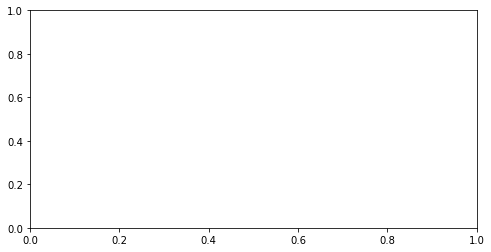

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
# MS-RWM
ax.plot(MS_RWM_MAN_0001.εs, label='MS-RWM-MAN-0001', markevery=[-1], marker='o')
ax.plot(MS_RWM_MAN_001.εs, label='MS-RWM-MAN-001', markevery=[-1], marker='o')
ax.plot(MS_RWM_MAN_01.εs, label='MS-RWM-MAN-01', markevery=[-1], marker='o')
# MS-RT
# ax.plot(MS_RT_MAN_0001.εs, label='MS-RT-MAN-0001', markevery=[-1], marker='o')
ax.plot(MS_RT_MAN_01.εs, label='MS-RT-MAN-01', markevery=[-1], marker='o')
# SMC-RWM
ax.plot(SMC_RWM_MAN_0001.εs, label='SMC-RWM-MAN-0001', markevery=[-1], marker='o')
ax.plot(SMC_RWM_MAN_001.εs, label='SMC-RWM-MAN-001', markevery=[-1], marker='o')
ax.plot(SMC_RWM_MAN_01.εs, label='SMC-RWM-MAN-01', markevery=[-1], marker='o')
# test
ax.plot(TEST2.εs, label='test2', markevery=[-1], marker='o')
# Prettify 
ax.legend()
ax.set_yscale('log')
ax.set_ylabel(r'$\mathregular{\varepsilon}$', fontsize=20)
ax.set_xlabel('Iteration')
plt.show()

# Save Data

In [21]:
MS_RWM_MAN_01 = MSAdaptive(SETTINGS_MANUAL_RWM_01)
_ = MS_RWM_MAN_01.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 9.9378205109852100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2004000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  2
	Trajectories constructed.
	Epsilon: 9.8861343525605001
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2364000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  3
	Trajectories constructed.
	Epsilon: 9.8438638811626511
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2508000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  4
	Trajectories constructed.
	Epsilon: 9.7952666501670098
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2638000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  5
	Trajectories constructed

	Epsilon: 8.2924348139913704
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2278000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  38
	Trajectories constructed.
	Epsilon: 8.2554883426580314
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2252000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  39
	Trajectories constructed.
	Epsilon: 8.2248865744087194
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2280000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  40
	Trajectories constructed.
	Epsilon: 8.1904675952871937
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2384000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  41
	Trajectories constructed.
	Epsilon: 8.1589961189799158
	Weights computed and normalized.
	Particles Resampled.
	Veloci

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2824000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  74
	Trajectories constructed.
	Epsilon: 6.2618372974742069
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2944000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  75
	Trajectories constructed.
	Epsilon: 6.2111053436410835
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2790000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 6.1672305488026042
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2796000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 6.1151450830602148
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 

	Epsilon: 4.9176894966406071
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1494000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  111
	Trajectories constructed.
	Epsilon: 4.8919608133012273
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1676000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  112
	Trajectories constructed.
	Epsilon: 4.8614699225767541
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1404000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  113
	Trajectories constructed.
	Epsilon: 4.8296109508630858
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1500000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  114
	Trajectories constructed.
	Epsilon: 4.7995207903601926
	Weights computed and normalized.
	Particles Resampled.
	Ve

	Epsilon: 4.1148086793541374
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0646000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  147
	Trajectories constructed.
	Epsilon: 4.0973403015771330
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0740000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  148
	Trajectories constructed.
	Epsilon: 4.0829405754281325
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0794000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  149
	Trajectories constructed.
	Epsilon: 4.0644370363280835
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0668000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  150
	Trajectories constructed.
	Epsilon: 4.0465369479532027
	Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0432000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  183
	Trajectories constructed.
	Epsilon: 3.5200042999653931
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0472000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  184
	Trajectories constructed.
	Epsilon: 3.5020866139978524
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0392000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  185
	Trajectories constructed.
	Epsilon: 3.4867958699203716
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0368000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  186
	Trajectories constructed.
	Epsilon: 3.4729961562127856
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0108000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  219
	Trajectories constructed.
	Epsilon: 3.1180438659802014
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0142000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  220
	Trajectories constructed.
	Epsilon: 3.1115368405365613
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0150000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  221
	Trajectories constructed.
	Epsilon: 3.1038154376138447
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0178000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  222
	Trajectories constructed.
	Epsilon: 3.0983513020344073
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0048000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  255
	Trajectories constructed.
	Epsilon: 2.8616143512708905
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0042000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  256
	Trajectories constructed.
	Epsilon: 2.8553605654215626
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0036000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  257
	Trajectories constructed.
	Epsilon: 2.8504276870171346
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0060000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  258
	Trajectories constructed.
	Epsilon: 2.8464496807383517
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0004000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  291
	Trajectories constructed.
	Epsilon: 2.7037895610035920
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0018000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  292
	Trajectories constructed.
	Epsilon: 2.7014277257191615
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0010000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  293
	Trajectories constructed.
	Epsilon: 2.6955816323267530
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0006000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  294
	Trajectories constructed.
	Epsilon: 2.6945514785263671
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

/Users/maurocamara/Documents/University/ManifoldSampling/markov_snippets.py:224: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


In [19]:
MS_RWM_MAN_ADAPT = MSAdaptive(SETTINGS_MANUAL_RWM_ADAPTIVE)
_ = MS_RWM_MAN_ADAPT.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 9.9378205109852100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8594000000000001
	Step-size adapted to: 0.0136984829481921
Iteration:  2
	Trajectories constructed.
	Epsilon: 9.8929085149930245
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8400000000000000
	Step-size adapted to: 0.0185837044707719
Iteration:  3
	Trajectories constructed.
	Epsilon: 9.8329039638311020
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8076000000000000
	Step-size adapted to: 0.0248059884305068
Iteration:  4
	Trajectories constructed.
	Epsilon: 9.7641910504471010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7632000000000000
	Step-size adapted to: 0.0323846677432360
Iteration:  5
	Trajectories constructed.
	Epsilon: 

	Epsilon: 8.1446841390070635
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2732000000000000
	Step-size adapted to: 0.1235795518207913
Iteration:  39
	Trajectories constructed.
	Epsilon: 8.0974437866153899
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2894000000000000
	Step-size adapted to: 0.1273049122747016
Iteration:  40
	Trajectories constructed.
	Epsilon: 8.0359481049499095
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2750000000000000
	Step-size adapted to: 0.1302017399028142
Iteration:  41
	Trajectories constructed.
	Epsilon: 7.9756603720028920
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2670000000000000
	Step-size adapted to: 0.1326328908996804
Iteration:  42
	Trajectories constructed.
	Epsilon: 7.9190601156918916
	Weights computed and normalized.
	Particles Resampled.
	Velocities refresh

	Epsilon: 6.1069553952647144
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2022000000000000
	Step-size adapted to: 0.1081895837175497
Iteration:  76
	Trajectories constructed.
	Epsilon: 6.0588259871445596
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1970000000000000
	Step-size adapted to: 0.1064191022261309
Iteration:  77
	Trajectories constructed.
	Epsilon: 6.0157288494232253
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2058000000000000
	Step-size adapted to: 0.1051391901730713
Iteration:  78
	Trajectories constructed.
	Epsilon: 5.9741484067816160
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2176000000000000
	Step-size adapted to: 0.1044893437994297
Iteration:  79
	Trajectories constructed.
	Epsilon: 5.9302189763184803
	Weights computed and normalized.
	Particles Resampled.
	Velocities refresh

	Epsilon: 4.8303508835638880
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2060000000000000
	Step-size adapted to: 0.0746107868793069
Iteration:  113
	Trajectories constructed.
	Epsilon: 4.8049504134069956
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2320000000000000
	Step-size adapted to: 0.0746854349840178
Iteration:  114
	Trajectories constructed.
	Epsilon: 4.7804067963343888
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2200000000000000
	Step-size adapted to: 0.0743129398230315
Iteration:  115
	Trajectories constructed.
	Epsilon: 4.7533635196654433
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2034000000000000
	Step-size adapted to: 0.0733311212894144
Iteration:  116
	Trajectories constructed.
	Epsilon: 4.7295029157785144
	Weights computed and normalized.
	Particles Resampled.
	Velocities ref

	Epsilon: 3.8955715102314428
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1968000000000000
	Step-size adapted to: 0.0592452194868594
Iteration:  150
	Trajectories constructed.
	Epsilon: 3.8759608771677541
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1992000000000000
	Step-size adapted to: 0.0583398324801082
Iteration:  151
	Trajectories constructed.
	Epsilon: 3.8570468656576367
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1908000000000000
	Step-size adapted to: 0.0572075048238797
Iteration:  152
	Trajectories constructed.
	Epsilon: 3.8372593425699462
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2096000000000000
	Step-size adapted to: 0.0566269541166489
Iteration:  153
	Trajectories constructed.
	Epsilon: 3.8155132832103393
	Weights computed and normalized.
	Particles Resampled.
	Velocities ref

	Trajectories constructed.
	Epsilon: 3.2640610814567879
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2396000000000000
	Step-size adapted to: 0.0438329182355754
Iteration:  187
	Trajectories constructed.
	Epsilon: 3.2481486692572528
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2134000000000000
	Step-size adapted to: 0.0434706106705599
Iteration:  188
	Trajectories constructed.
	Epsilon: 3.2328971018737960
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2210000000000000
	Step-size adapted to: 0.0432754324030076
Iteration:  189
	Trajectories constructed.
	Epsilon: 3.2159301643610645
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2204000000000000
	Step-size adapted to: 0.0430682080637579
Iteration:  190
	Trajectories constructed.
	Epsilon: 3.1993292608973771
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 2.7829774336203137
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2146000000000000
	Step-size adapted to: 0.0338922065607725
Iteration:  224
	Trajectories constructed.
	Epsilon: 2.7717691258659807
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2278000000000000
	Step-size adapted to: 0.0338549456308242
Iteration:  225
	Trajectories constructed.
	Epsilon: 2.7587067495813420
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2278000000000000
	Step-size adapted to: 0.0338177256653643
Iteration:  226
	Trajectories constructed.
	Epsilon: 2.7483100024995295
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2170000000000000
	Step-size adapted to: 0.0335986233026407
Iteration:  227
	Trajectories constructed.
	Epsilon: 2.7374104078538961
	Weights computed and normalized.
	Particles

	Velocities refreshed.
	Prop Moved: 0.2134000000000000
	Step-size adapted to: 0.0265886675483694
Iteration:  260
	Trajectories constructed.
	Epsilon: 2.4483248707337824
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2226000000000000
	Step-size adapted to: 0.0264904712536113
Iteration:  261
	Trajectories constructed.
	Epsilon: 2.4410200773508266
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2298000000000000
	Step-size adapted to: 0.0264878223389339
Iteration:  262
	Trajectories constructed.
	Epsilon: 2.4335149276488122
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2178000000000000
	Step-size adapted to: 0.0263267384280885
Iteration:  263
	Trajectories constructed.
	Epsilon: 2.4264311210150371
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2280000000000000
	Step-size adapted to: 0.0263004248486430
Ite

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2048000000000000
	Step-size adapted to: 0.0210328414139043
Iteration:  297
	Trajectories constructed.
	Epsilon: 2.2050181647553950
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2334000000000000
	Step-size adapted to: 0.0210686276539935
Iteration:  298
	Trajectories constructed.
	Epsilon: 2.1995513482464180
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2212000000000000
	Step-size adapted to: 0.0209761293378421
Iteration:  299
	Trajectories constructed.
	Epsilon: 2.1933956298902886
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2224000000000000
	Step-size adapted to: 0.0208965713023605
Iteration:  300
	Trajectories constructed.
	Epsilon: 2.1883707676594488
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.222600

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2294000000000000
	Step-size adapted to: 0.0196619460091917
Iteration:  334
	Trajectories constructed.
	Epsilon: 2.0032072065462678
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2250000000000000
	Step-size adapted to: 0.0196128525365790
Iteration:  335
	Trajectories constructed.
	Epsilon: 1.9972209454704333
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2352000000000000
	Step-size adapted to: 0.0196639123021056
Iteration:  336
	Trajectories constructed.
	Epsilon: 1.9921757152124386
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2274000000000000
	Step-size adapted to: 0.0196383658249209
Iteration:  337
	Trajectories constructed.
	Epsilon: 1.9862367491806345
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.236600

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2200000000000000
	Step-size adapted to: 0.0190999380767823
Iteration:  371
	Trajectories constructed.
	Epsilon: 1.7610390203738153
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2118000000000000
	Step-size adapted to: 0.0189269170798072
Iteration:  372
	Trajectories constructed.
	Epsilon: 1.7550503370957817
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2036000000000000
	Step-size adapted to: 0.0186787234560316
Iteration:  373
	Trajectories constructed.
	Epsilon: 1.7494328254077645
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2068000000000000
	Step-size adapted to: 0.0184633021232575
Iteration:  374
	Trajectories constructed.
	Epsilon: 1.7438067483015010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.215800

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2320000000000000
	Step-size adapted to: 0.0156470921247082
Iteration:  408
	Trajectories constructed.
	Epsilon: 1.5808444192016364
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2290000000000000
	Step-size adapted to: 0.0156392705342065
Iteration:  409
	Trajectories constructed.
	Epsilon: 1.5762901388649058
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2446000000000000
	Step-size adapted to: 0.0157538549333131
Iteration:  410
	Trajectories constructed.
	Epsilon: 1.5715163765114992
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2422000000000000
	Step-size adapted to: 0.0158502471457583
Iteration:  411
	Trajectories constructed.
	Epsilon: 1.5666355142116581
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.244800

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2088000000000000
	Step-size adapted to: 0.0134097907479758
Iteration:  445
	Trajectories constructed.
	Epsilon: 1.4139564333819994
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2138000000000000
	Step-size adapted to: 0.0133016101657518
Iteration:  446
	Trajectories constructed.
	Epsilon: 1.4105661235514602
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2232000000000000
	Step-size adapted to: 0.0132564614874346
Iteration:  447
	Trajectories constructed.
	Epsilon: 1.4072749997291614
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2004000000000000
	Step-size adapted to: 0.0130617105690571
Iteration:  448
	Trajectories constructed.
	Epsilon: 1.4039059352446892
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.206800

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2324000000000000
	Step-size adapted to: 0.0117374559663779
Iteration:  482
	Trajectories constructed.
	Epsilon: 1.2955207911913675
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2332000000000000
	Step-size adapted to: 0.0117562509278837
Iteration:  483
	Trajectories constructed.
	Epsilon: 1.2923473165436270
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2224000000000000
	Step-size adapted to: 0.0117116619470767
Iteration:  484
	Trajectories constructed.
	Epsilon: 1.2889750295843929
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2186000000000000
	Step-size adapted to: 0.0116450953689549
Iteration:  485
	Trajectories constructed.
	Epsilon: 1.2858530256831986
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.259000

# MS-RT

In [22]:
MS_RT_MAN_0001 = MSAdaptive(SETTINGS_MANUAL_RT_0001)
_ = MS_RT_MAN_0001.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 9.9378205109852100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9414000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Trajectories constructed.
	Epsilon: 9.8986759807570230
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9422000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Trajectories constructed.
	Epsilon: 9.8595426516238085
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9462000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Trajectories constructed.
	Epsilon: 9.8179304491497383
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9480000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  5
	Trajectories constructed

	Epsilon: 8.4127298781438515
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9458000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  38
	Trajectories constructed.
	Epsilon: 8.3818831868031172
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9498000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  39
	Trajectories constructed.
	Epsilon: 8.3519966305030664
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9492000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  40
	Trajectories constructed.
	Epsilon: 8.3227952685222828
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9419999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  41
	Trajectories constructed.
	Epsilon: 8.2949994114918937
	Weights computed and normalized.
	Particles Resampled.
	Veloci

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9452000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  74
	Trajectories constructed.
	Epsilon: 7.3146819499310709
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9496000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  75
	Trajectories constructed.
	Epsilon: 7.2804452668445787
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9450000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 7.2474527315328601
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9376000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 7.2142130298856602
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 

	Epsilon: 6.3956821351536606
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9446000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  111
	Trajectories constructed.
	Epsilon: 6.3704577657299648
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9418000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  112
	Trajectories constructed.
	Epsilon: 6.3468779925802759
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9454000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  113
	Trajectories constructed.
	Epsilon: 6.3227642885533086
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9436000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  114
	Trajectories constructed.
	Epsilon: 6.2998401893813982
	Weights computed and normalized.
	Particles Resampled.
	Ve

	Epsilon: 5.6115403219272979
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9429999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  147
	Trajectories constructed.
	Epsilon: 5.5891526781971539
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9396000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  148
	Trajectories constructed.
	Epsilon: 5.5693297021687656
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9409999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  149
	Trajectories constructed.
	Epsilon: 5.5489278419469201
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9448000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  150
	Trajectories constructed.
	Epsilon: 5.5272222910590214
	Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9416000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  183
	Trajectories constructed.
	Epsilon: 4.8239359870084710
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9460000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  184
	Trajectories constructed.
	Epsilon: 4.8013428625886023
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9444000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  185
	Trajectories constructed.
	Epsilon: 4.7817350565003860
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9450000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  186
	Trajectories constructed.
	Epsilon: 4.7613457118481781
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9398000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  219
	Trajectories constructed.
	Epsilon: 4.1498063246439001
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9399999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  220
	Trajectories constructed.
	Epsilon: 4.1325834563966426
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9392000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  221
	Trajectories constructed.
	Epsilon: 4.1162544924342832
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9316000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  222
	Trajectories constructed.
	Epsilon: 4.1001642042653073
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9364000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  255
	Trajectories constructed.
	Epsilon: 3.5485383522934955
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9388000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  256
	Trajectories constructed.
	Epsilon: 3.5304022136401643
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9372000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  257
	Trajectories constructed.
	Epsilon: 3.5141609818884767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9306000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  258
	Trajectories constructed.
	Epsilon: 3.4995329265705082
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9290000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  291
	Trajectories constructed.
	Epsilon: 3.0030906575704317
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9272000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  292
	Trajectories constructed.
	Epsilon: 2.9913419798967591
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9344000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  293
	Trajectories constructed.
	Epsilon: 2.9784327136086404
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9316000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  294
	Trajectories constructed.
	Epsilon: 2.9658953021584096
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9236000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  327
	Trajectories constructed.
	Epsilon: 2.5532711746384464
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9244000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  328
	Trajectories constructed.
	Epsilon: 2.5416548077111387
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9228000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  329
	Trajectories constructed.
	Epsilon: 2.5302598258258948
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9270000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  330
	Trajectories constructed.
	Epsilon: 2.5190419692396238
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9142000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  363
	Trajectories constructed.
	Epsilon: 2.1836694591922350
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9182000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  364
	Trajectories constructed.
	Epsilon: 2.1743420693469759
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9236000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  365
	Trajectories constructed.
	Epsilon: 2.1652329866706008
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9100000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  366
	Trajectories constructed.
	Epsilon: 2.1564829265725174
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9042000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  399
	Trajectories constructed.
	Epsilon: 1.8870992514615985
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9084000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  400
	Trajectories constructed.
	Epsilon: 1.8788151823695451
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9088000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  401
	Trajectories constructed.
	Epsilon: 1.8708626528870576
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9060000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  402
	Trajectories constructed.
	Epsilon: 1.8629500889178481
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9022000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  435
	Trajectories constructed.
	Epsilon: 1.6303938334912338
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8942000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  436
	Trajectories constructed.
	Epsilon: 1.6236864161967226
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8940000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  437
	Trajectories constructed.
	Epsilon: 1.6162836526818993
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8950000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  438
	Trajectories constructed.
	Epsilon: 1.6095223731287693
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8730000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  471
	Trajectories constructed.
	Epsilon: 1.4072540562182079
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8746000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  472
	Trajectories constructed.
	Epsilon: 1.4010557446616922
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8816000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  473
	Trajectories constructed.
	Epsilon: 1.3953043498499462
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8812000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  474
	Trajectories constructed.
	Epsilon: 1.3889620479899412
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

In [25]:
MS_RT_MAN_001 = MSAdaptive(SETTINGS_MANUAL_RT_001)
_ = MS_RT_MAN_001.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 9.9378205109852100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8572000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Trajectories constructed.
	Epsilon: 9.8875390853937510
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8663999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Trajectories constructed.
	Epsilon: 9.8306915972428808
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8796000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Trajectories constructed.
	Epsilon: 9.7656218283584995
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8894000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  5
	Trajectories constructed

	Epsilon: 8.0060865743479361
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8702000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  38
	Trajectories constructed.
	Epsilon: 7.9674752394965065
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8774000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  39
	Trajectories constructed.
	Epsilon: 7.9255703709111778
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8778000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  40
	Trajectories constructed.
	Epsilon: 7.8815312044299013
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8934000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  41
	Trajectories constructed.
	Epsilon: 7.8316241202516022
	Weights computed and normalized.
	Particles Resampled.
	Veloci

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8618000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  74
	Trajectories constructed.
	Epsilon: 6.0949036454080217
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8586000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  75
	Trajectories constructed.
	Epsilon: 6.0585711304207379
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8566000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 6.0262959482250000
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8498000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 5.9925668679314921
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 

	Epsilon: 4.8874774896962183
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8102000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  111
	Trajectories constructed.
	Epsilon: 4.8625873258378975
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7904000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  112
	Trajectories constructed.
	Epsilon: 4.8403364226105685
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8042000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  113
	Trajectories constructed.
	Epsilon: 4.8168427377430110
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7972000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  114
	Trajectories constructed.
	Epsilon: 4.7953983475516573
	Weights computed and normalized.
	Particles Resampled.
	Ve

	Epsilon: 4.2012692160244764
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7514000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  147
	Trajectories constructed.
	Epsilon: 4.1867871857668852
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7388000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  148
	Trajectories constructed.
	Epsilon: 4.1719047040491830
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7524000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  149
	Trajectories constructed.
	Epsilon: 4.1583398471974888
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7413999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  150
	Trajectories constructed.
	Epsilon: 4.1425028801565604
	Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7198000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  183
	Trajectories constructed.
	Epsilon: 3.6285649312837527
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7218000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  184
	Trajectories constructed.
	Epsilon: 3.6128764418174817
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7166000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Trajectories constructed.
	Epsilon: 3.5978436714030133
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7278000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Trajectories constructed.
	Epsilon: 3.5826115405689443
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7168000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  219
	Trajectories constructed.
	Epsilon: 3.1573998959151783
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6992000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  220
	Trajectories constructed.
	Epsilon: 3.1423529899766249
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7174000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  221
	Trajectories constructed.
	Epsilon: 3.1261991225431740
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7094000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  222
	Trajectories constructed.
	Epsilon: 3.1113568281356461
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6080000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Trajectories constructed.
	Epsilon: 2.7027261245078256
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6132000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  256
	Trajectories constructed.
	Epsilon: 2.6931201090986581
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6156000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  257
	Trajectories constructed.
	Epsilon: 2.6845704649403004
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6114000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  258
	Trajectories constructed.
	Epsilon: 2.6755704414200383
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5768000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  291
	Trajectories constructed.
	Epsilon: 2.4024792610993275
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5880000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  292
	Trajectories constructed.
	Epsilon: 2.3937278023803596
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5964000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  293
	Trajectories constructed.
	Epsilon: 2.3849010161971056
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5990000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  294
	Trajectories constructed.
	Epsilon: 2.3765243663246296
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5268000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  327
	Trajectories constructed.
	Epsilon: 2.0972643896480845
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5356000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  328
	Trajectories constructed.
	Epsilon: 2.0905996477661812
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5392000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  329
	Trajectories constructed.
	Epsilon: 2.0835445816125602
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5175999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  330
	Trajectories constructed.
	Epsilon: 2.0771951645244422
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4490000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  363
	Trajectories constructed.
	Epsilon: 1.8964330952410284
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4702000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  364
	Trajectories constructed.
	Epsilon: 1.8910603608525394
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4470000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  365
	Trajectories constructed.
	Epsilon: 1.8857995462517221
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4542000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  366
	Trajectories constructed.
	Epsilon: 1.8808680120422416
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3894000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  399
	Trajectories constructed.
	Epsilon: 1.7442039347868752
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3914000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  400
	Trajectories constructed.
	Epsilon: 1.7405053948844489
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3892000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  401
	Trajectories constructed.
	Epsilon: 1.7363407873887178
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3958000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  402
	Trajectories constructed.
	Epsilon: 1.7321959384092607
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4068000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  435
	Trajectories constructed.
	Epsilon: 1.5510645111734263
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4066000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  436
	Trajectories constructed.
	Epsilon: 1.5465534772062934
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4118000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  437
	Trajectories constructed.
	Epsilon: 1.5416989010457685
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3970000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  438
	Trajectories constructed.
	Epsilon: 1.5369339822343460
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3024000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  471
	Trajectories constructed.
	Epsilon: 1.4091368366248480
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3120000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  472
	Trajectories constructed.
	Epsilon: 1.4059575158593374
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3228000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  473
	Trajectories constructed.
	Epsilon: 1.4025439362736483
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3132000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  474
	Trajectories constructed.
	Epsilon: 1.3993881932568655
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

In [28]:
MS_RT_MAN_01 = MSAdaptive(SETTINGS_MANUAL_RT_01)
_ = MS_RT_MAN_01.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 9.9378205109852100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2022000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  2
	Trajectories constructed.
	Epsilon: 9.8872330159823427
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2310000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  3
	Trajectories constructed.
	Epsilon: 9.8414708094418373
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2632000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  4
	Trajectories constructed.
	Epsilon: 9.7934470771380635
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2888000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  5
	Trajectories constructed

	Epsilon: 8.2870434061344866
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2350000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  38
	Trajectories constructed.
	Epsilon: 8.2569092411415941
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2424000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  39
	Trajectories constructed.
	Epsilon: 8.2233243269438834
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2378000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  40
	Trajectories constructed.
	Epsilon: 8.1902786704950028
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2444000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  41
	Trajectories constructed.
	Epsilon: 8.1544014838940004
	Weights computed and normalized.
	Particles Resampled.
	Veloci

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2382000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  74
	Trajectories constructed.
	Epsilon: 6.6473150098133944
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2326000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  75
	Trajectories constructed.
	Epsilon: 6.6018878662334926
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2332000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 6.5591930037503552
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2288000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 6.5232684528012479
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 

	Epsilon: 5.5603935309839718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1266000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  111
	Trajectories constructed.
	Epsilon: 5.5377038482526721
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1144000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  112
	Trajectories constructed.
	Epsilon: 5.5154134833267197
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1232000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  113
	Trajectories constructed.
	Epsilon: 5.4931014584380629
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1114000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  114
	Trajectories constructed.
	Epsilon: 5.4709331990009122
	Weights computed and normalized.
	Particles Resampled.
	Ve

	Epsilon: 4.6737166180037075
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1048000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  147
	Trajectories constructed.
	Epsilon: 4.6462390380681819
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0972000000000000
	Step-size kept fixed at: 0.1000000000000000


####################################
### SWITCHING TO THUG INTEGRATOR ###
####################################


Iteration:  148
	Trajectories constructed.
	Epsilon: 4.6195616344446142
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9542000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  149
	Trajectories constructed.
	Epsilon: 4.5955505329266595
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  150


	Trajectories constructed.
	Epsilon: 4.0673242201702555
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9530000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  183
	Trajectories constructed.
	Epsilon: 4.0575194839846480
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9516000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  184
	Trajectories constructed.
	Epsilon: 4.0437376469368465
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9556000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  185
	Trajectories constructed.
	Epsilon: 3.9872422248915482
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9472000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  186
	Trajectories constructed.
	Epsilon: 3.9486271254816891
	Weights computed and normalized

In [30]:
MS_RT_MAN_ADAPT = MSAdaptive(SETTINGS_MANUAL_RT_ADAPTIVE)
_ = MS_RT_MAN_ADAPT.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 9.9378205109852100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8538000000000000
	Step-size adapted to: 0.0136601808439072
Iteration:  2
	Trajectories constructed.
	Epsilon: 9.8877625959981383
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8240000000000000
	Step-size adapted to: 0.0183840803729582
Iteration:  3
	Trajectories constructed.
	Epsilon: 9.8295948726789319
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8058000000000000
	Step-size adapted to: 0.0245174496094720
Iteration:  4
	Trajectories constructed.
	Epsilon: 9.7634378745003865
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7716000000000000
	Step-size adapted to: 0.0321426912811581
Iteration:  5
	Trajectories constructed.
	Epsilon: 

	Epsilon: 8.1091766888934007
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2784000000000000
	Step-size adapted to: 0.1203838145263779
Iteration:  39
	Trajectories constructed.
	Epsilon: 8.0642591514829771
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2666000000000000
	Step-size adapted to: 0.1226071195264230
Iteration:  40
	Trajectories constructed.
	Epsilon: 8.0159034733075938
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2640000000000000
	Step-size adapted to: 0.1247092581100728
Iteration:  41
	Trajectories constructed.
	Epsilon: 7.9593068839404735
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2638000000000000
	Step-size adapted to: 0.1268347544276740
Iteration:  42
	Trajectories constructed.
	Epsilon: 7.9045853769059677
	Weights computed and normalized.
	Particles Resampled.
	Velocities refresh

	Epsilon: 6.1477356422168139
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2296000000000000
	Step-size adapted to: 0.1133618701846802
Iteration:  76
	Trajectories constructed.
	Epsilon: 6.0907563133754508
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2298000000000000
	Step-size adapted to: 0.1133505345644522
Iteration:  77
	Trajectories constructed.
	Epsilon: 6.0470982164105358
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2160000000000000
	Step-size adapted to: 0.1125598514420495
Iteration:  78
	Trajectories constructed.
	Epsilon: 5.9968156997720410
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2264000000000000
	Step-size adapted to: 0.1123574259470542
Iteration:  79
	Trajectories constructed.
	Epsilon: 5.9454335725453653
	Weights computed and normalized.
	Particles Resampled.
	Velocities refresh

	Epsilon: 4.6382176503816570
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2070000000000000
	Step-size adapted to: 0.0753531020667406
Iteration:  113
	Trajectories constructed.
	Epsilon: 4.6077560618472191
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2126000000000000
	Step-size adapted to: 0.0747003735648232
Iteration:  114
	Trajectories constructed.
	Epsilon: 4.5839660807807743
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1910000000000000
	Step-size adapted to: 0.0732578268214671
Iteration:  115
	Trajectories constructed.
	Epsilon: 4.5575873548397325
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2064000000000000
	Step-size adapted to: 0.0723984646730915
Iteration:  116
	Trajectories constructed.
	Epsilon: 4.5342056495821570
	Weights computed and normalized.
	Particles Resampled.
	Velocities ref

	Trajectories constructed.
	Epsilon: 3.7954514189798649
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2326000000000000
	Step-size adapted to: 0.0560915452712711
Iteration:  150
	Trajectories constructed.
	Epsilon: 3.7758532452292393
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2172000000000000
	Step-size adapted to: 0.0557337056896212
Iteration:  151
	Trajectories constructed.
	Epsilon: 3.7548528595631647
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2278000000000000
	Step-size adapted to: 0.0556724323198943
Iteration:  152
	Trajectories constructed.
	Epsilon: 3.7328673507261976
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2204000000000000
	Step-size adapted to: 0.0554058449662551
Iteration:  153
	Trajectories constructed.
	Epsilon: 3.7145920366539853
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 3.1904379045365179
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2228000000000000
	Step-size adapted to: 0.0387869982178739
Iteration:  187
	Trajectories constructed.
	Epsilon: 3.1794829563369724
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2152000000000000
	Step-size adapted to: 0.0385010338043415
Iteration:  188
	Trajectories constructed.
	Epsilon: 3.1680490629419897
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2192000000000000
	Step-size adapted to: 0.0382936885578123
Iteration:  189
	Trajectories constructed.
	Epsilon: 3.1566888662195995
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2250000000000000
	Step-size adapted to: 0.0381980739045337
Iteration:  190
	Trajectories constructed.
	Epsilon: 3.1446668641625721
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 2.7827841705272500
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2144000000000000
	Step-size adapted to: 0.0332476834166189
Iteration:  224
	Trajectories constructed.
	Epsilon: 2.7727424765350808
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2246000000000000
	Step-size adapted to: 0.0331580357502046
Iteration:  225
	Trajectories constructed.
	Epsilon: 2.7619734498165007
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2084000000000000
	Step-size adapted to: 0.0328018557979072
Iteration:  226
	Trajectories constructed.
	Epsilon: 2.7533462339580845
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2246000000000000
	Step-size adapted to: 0.0327134102424834
Iteration:  227
	Trajectories constructed.
	Epsilon: 2.7438793252115641
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 2.3696385324594655
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2370000000000000
	Step-size adapted to: 0.0320239830690364
Iteration:  261
	Trajectories constructed.
	Epsilon: 2.3573176652037175
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2392000000000000
	Step-size adapted to: 0.0321716327250073
Iteration:  262
	Trajectories constructed.
	Epsilon: 2.3444362341574041
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2384000000000000
	Step-size adapted to: 0.0323070377339257
Iteration:  263
	Trajectories constructed.
	Epsilon: 2.3306944938152241
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2384000000000000
	Step-size adapted to: 0.0324430126398276
Iteration:  264
	Trajectories constructed.
	Epsilon: 2.3184269268788880
	Weights computed and normalized.
	Particles

	Velocities refreshed.
	Prop Moved: 0.2214000000000000
	Step-size adapted to: 0.0248308068260668
Iteration:  297
	Trajectories constructed.
	Epsilon: 1.9685544256531440
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2156000000000000
	Step-size adapted to: 0.0246526670895336
Iteration:  298
	Trajectories constructed.
	Epsilon: 1.9603419941402944
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2140000000000000
	Step-size adapted to: 0.0244562325386706
Iteration:  299
	Trajectories constructed.
	Epsilon: 1.9521629867980839
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2118000000000000
	Step-size adapted to: 0.0242346903682676
Iteration:  300
	Trajectories constructed.
	Epsilon: 1.9442101650411094
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1922000000000000
	Step-size adapted to: 0.0237809560163895
Ite

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2118000000000000
	Step-size adapted to: 0.0171086655591293
Iteration:  334
	Trajectories constructed.
	Epsilon: 1.7420344165108126
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2142000000000000
	Step-size adapted to: 0.0169740395740200
Iteration:  335
	Trajectories constructed.
	Epsilon: 1.7378742207842344
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2202000000000000
	Step-size adapted to: 0.0168910702210299
Iteration:  336
	Trajectories constructed.
	Epsilon: 1.7328644846196950
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2194000000000000
	Step-size adapted to: 0.0168017843653791
Iteration:  337
	Trajectories constructed.
	Epsilon: 1.7285466961894425
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.221000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2090000000000000
	Step-size adapted to: 0.0138306216353696
Iteration:  371
	Trajectories constructed.
	Epsilon: 1.5948213119843579
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2154000000000000
	Step-size adapted to: 0.0137300257192545
Iteration:  372
	Trajectories constructed.
	Epsilon: 1.5917239685987565
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2150000000000000
	Step-size adapted to: 0.0136274357197485
Iteration:  373
	Trajectories constructed.
	Epsilon: 1.5885488323752359
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1894000000000000
	Step-size adapted to: 0.0133535877357782
Iteration:  374
	Trajectories constructed.
	Epsilon: 1.5858211571056380
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.217000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2162000000000000
	Step-size adapted to: 0.0120418140001239
Iteration:  408
	Trajectories constructed.
	Epsilon: 1.4888761244737236
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2360000000000000
	Step-size adapted to: 0.0120779936845161
Iteration:  409
	Trajectories constructed.
	Epsilon: 1.4860853301422583
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2222000000000000
	Step-size adapted to: 0.0120309812429957
Iteration:  410
	Trajectories constructed.
	Epsilon: 1.4835917740733313
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2216000000000000
	Step-size adapted to: 0.0119805570866270
Iteration:  411
	Trajectories constructed.
	Epsilon: 1.4809208663779010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.227000